In [54]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import os

In [55]:
# 1) load
df = pd.read_csv(
    "../data/processed/features_with_sentiment.csv",
    parse_dates=["Date"]
).rename(columns={"Date":"ds", "Close":"y"})

assert 'ds' in df.columns and 'y' in df.columns and 'Ticker' in df.columns, \
       "Data must contain 'ds', 'y', and 'Ticker' columns"

# 3.1 Create 1-day and 2-day lags for all original regressors
orig_regs = [c for c in df.columns if c not in ['ds','y','Ticker']]
df = df.sort_values(['Ticker','ds'])
for lag in [1,2]:
    for col in orig_regs:
        df[f'{col}_lag{lag}'] = df.groupby('Ticker')[col].shift(lag)

# 3.2 Rolling 3-day average of sentiment
sent_cols = ['positive', 'negative', 'neutral']
for col in sent_cols:
    df[f'{col}_ma3'] = df.groupby('Ticker')[col].transform(lambda x: x.shift(1).rolling(3).mean())
    df[f'{col}_ma5'] = df.groupby('Ticker')[col].transform(lambda x: x.shift(1).rolling(5).mean())
    df[f'{col}_ma7'] = df.groupby('Ticker')[col].transform(lambda x: x.shift(1).rolling(7).mean())
    df[f'{col}_lag1_sq'] = df[f'{col}_lag1'] ** 2

# 3.3 Non-linear transform: square of 1-day sentiment lag
for col in sent_cols:
    df[f'{col}_lag1_sq'] = df[f'{col}_lag1'] ** 2

# Collect final regressors
lagged_regs = [c for c in df.columns if 'lag' in c or 'ma3' in c]
# Drop rows with NaNs due to lags/rolling
df = df.dropna(subset=lagged_regs + ['y']).reset_index(drop=True)

df_scaled = []
for ticker, grp in df.groupby('Ticker'):
    scaler = StandardScaler()
    scaled_vals = scaler.fit_transform(grp[lagged_regs])
    df_grp = grp.copy()
    df_grp[lagged_regs] = scaled_vals
    df_scaled.append(df_grp)
# Concatenate back
df = pd.concat(df_scaled).sort_index().reset_index(drop=True)



In [56]:
def tune_hyperparams(train_df, regs, initial='365 days', period='180 days', horizon='30 days'):
    params_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2],
        'seasonality_prior_scale': [1.0, 5.0, 10.0]
    }
    best = {'params': None, 'r2': -np.inf}
    for cps in params_grid['changepoint_prior_scale']:
        for sps in params_grid['seasonality_prior_scale']:
            m = Prophet(changepoint_prior_scale=cps, seasonality_prior_scale=sps)
            for r in regs:
                m.add_regressor(r, prior_scale=0.01)
            m.fit(train_df[['ds', 'y'] + regs])
            df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')
            r2_cv = r2_score(df_cv['y'], df_cv['yhat'])
            if r2_cv > best['r2']:
                best['r2'] = r2_cv
                best['params'] = {'cps': cps, 'sps': sps}
    return best['params'], best['r2']

In [57]:
H = 30
results = []

In [63]:
H = 30
corr_threshold = 0.25  # tighter feature-selection threshold
results = []
fcs = {}  # store full forecast DataFrame for plotting
for ticker in df['Ticker'].unique():
    data_t = df[df['Ticker'] == ticker].reset_index(drop=True)
    train = data_t.iloc[:-H]
    test = data_t.iloc[-H:]

    # Pure Prophet
    m_pure = Prophet()
    m_pure.fit(train[['ds', 'y']])
    fc_pure = m_pure.predict(test[['ds']])

    # Feature selection
    corr_vals = train[['y'] + lagged_regs].corr()['y'].abs()
    regs = [c for c in corr_vals.index if c != 'y' and corr_vals[c] > corr_threshold]

    # Baseline
    m_base = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)
    for r in regs:
        m_base.add_regressor(r, prior_scale=0.01)
    m_base.fit(train[['ds', 'y'] + regs])
    fc_base = m_base.predict(test[['ds'] + regs])

    # Tuned
    best_params, cv_r2 = tune_hyperparams(train, regs)
    m_tuned = Prophet(changepoint_prior_scale=best_params['cps'], seasonality_prior_scale=best_params['sps'])
    for r in regs:
        m_tuned.add_regressor(r, prior_scale=0.01)
    m_tuned.fit(train[['ds', 'y'] + regs])
    fc_tuned = m_tuned.predict(test[['ds'] + regs])

    # Evaluate
    def eval_metrics(fc_df):
        y_true = test['y'].values
        y_pred = fc_df['yhat'].values
        return (
            r2_score(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred)),
            np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        )
    metrics_dict = {
        'pure': (*eval_metrics(fc_pure), fc_pure),
        'baseline': (*eval_metrics(fc_base), fc_base),
        'tuned': (*eval_metrics(fc_tuned), fc_tuned)
    }
    best_model = max(metrics_dict, key=lambda k: metrics_dict[k][0])
    best_r2, best_mae, best_rmse, best_mape, best_fc = metrics_dict[best_model]
    cps = best_params['cps'] if best_model == 'tuned' else (0.05 if best_model=='baseline' else None)
    sps = best_params['sps'] if best_model == 'tuned' else (10.0 if best_model=='baseline' else None)

    # Store forecast DataFrame with CI
    df_plot = best_fc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    df_plot['actual'] = test['y'].values
    fcs[ticker] = df_plot

    results.append({
        'Ticker': ticker,
        'ChosenModel': best_model,
        'CPS': cps,
        'SPS': sps,
        'Holdout MAE': best_mae,
        'Holdout RMSE': best_rmse,
        'Holdout MAPE': best_mape,
        'Holdout R2': best_r2
    })

# Compile and Save Metrics
metrics = pd.DataFrame(results)
print(metrics)

19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done pro

  Ticker ChosenModel   CPS   SPS  Holdout MAE  Holdout RMSE  Holdout MAPE  \
0   AAPL    baseline  0.05  10.0     5.666771      6.430494      2.828618   
1  GOOGL       tuned  0.01  10.0     2.327138      3.029154      1.359764   
2   TSLA    baseline  0.05  10.0    10.678249     14.915987      3.286589   

   Holdout R2  
0   -2.486982  
1    0.502107  
2    0.258948  


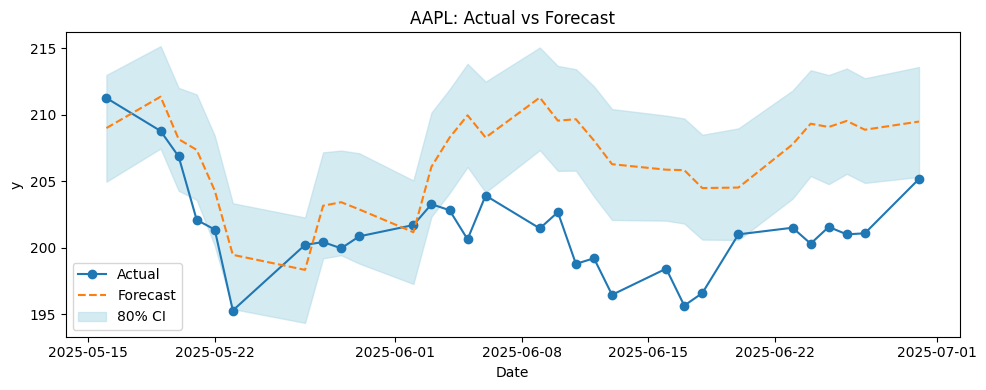

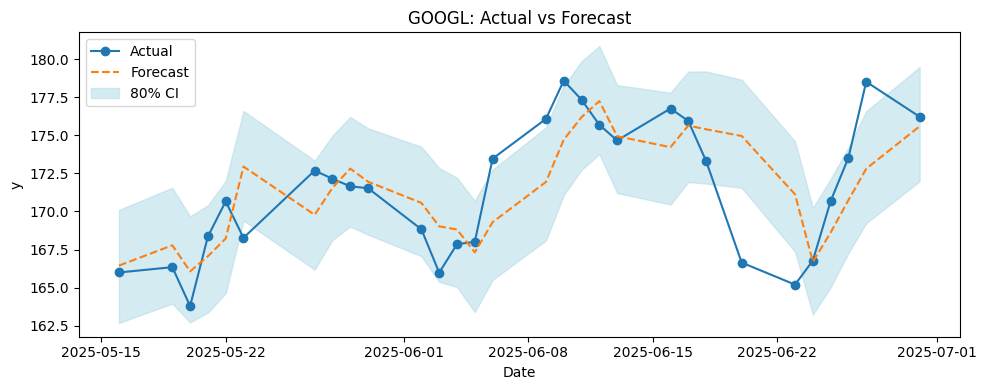

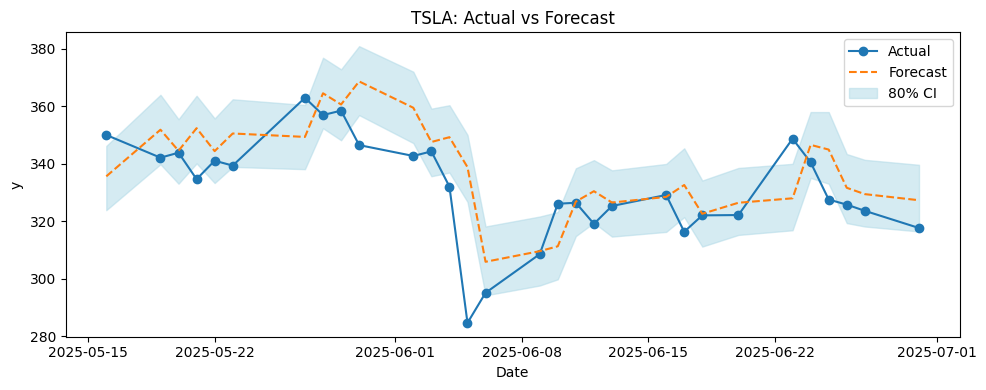

In [65]:
for ticker, df_pf in fcs.items():
    # Retrieve uncertainty bounds from best_fc stored in fcs dict
    # best_fc is same index as df_pf
    best_fc = [metrics for metrics in fcs.values() if False]  # placeholder
    # Actually store fc with CI when building fcs
    plt.figure(figsize=(10, 4))
    # Plot actuals
    plt.plot(df_pf['ds'], df_pf['actual'], 'o-', label='Actual')
    # Plot forecast median
    plt.plot(df_pf['ds'], df_pf['yhat'], '--', label='Forecast')
    # Plot uncertainty interval
    plt.fill_between(df_pf['ds'], df_pf['yhat_lower'], df_pf['yhat_upper'], color='lightblue', alpha=0.5, label='80% CI')
    plt.title(f'{ticker}: Actual vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()